In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
class MeanFieldVariationalMixtureDistribution(nn.Module):
    def __init__(self, proportions, components, device='cpu'):
        self.proportions = proportions
        self.components = components
        self.requires_grad_(False)
        
    def sample(self, n=1):
        d = torch.distributions.multinomial.Multinomial(n, self.proportions)
        m = d.sample()
        return torch.cat([self.components[c].sample(int(m[c])) for c in range(len(self.components))])
        
    def requires_grad_(self, b):
        self.proportions.requires_grad_(b) 
        for c in components:
            c.requires_grad_(b)
        
    def log_prob(self, x):
        return torch.logsumexp(torch.stack([torch.log(self.proportions[c]) + self.components[c].log_prob(x) for c in range(len(self.proportions))],dim=1),dim=1)
    
    def log_prob_augmented(self, x, q_new, unbounded_prop_new):
        prop_new = torch.sigmoid(unbounded_prop_new)
        A = torch.log(1-prop_new) + self.log_prob(x)
        B = torch.log(prop_new) + q_new.log_prob(x)
        return torch.logsumexp(torch.stack([A,B]),dim=0)

In [54]:
def log_prob_augmented(x,q, q_new, prop_new):
        A = torch.log(1-prop_new) + q.log_prob(x)
        B = torch.log(prop_new) + q_new.log_prob(x)
        return torch.logsumexp(torch.stack([A,B]),dim=0)

# Target density #

In [5]:
target_component = [torch.distributions.normal.Normal(-1.0, 0.3),
           torch.distributions.normal.Normal(1.0, 0.2)]
     #      torch.distributions.normal.Normal(-5.0, 0.2)]
target_proportions = torch.tensor([0.6, 0.4,
                                  ])#0.20])

In [6]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_component)
    for j in range(len(target_component)):
        logp[j] = target_component[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

<IPython.core.display.Javascript object>


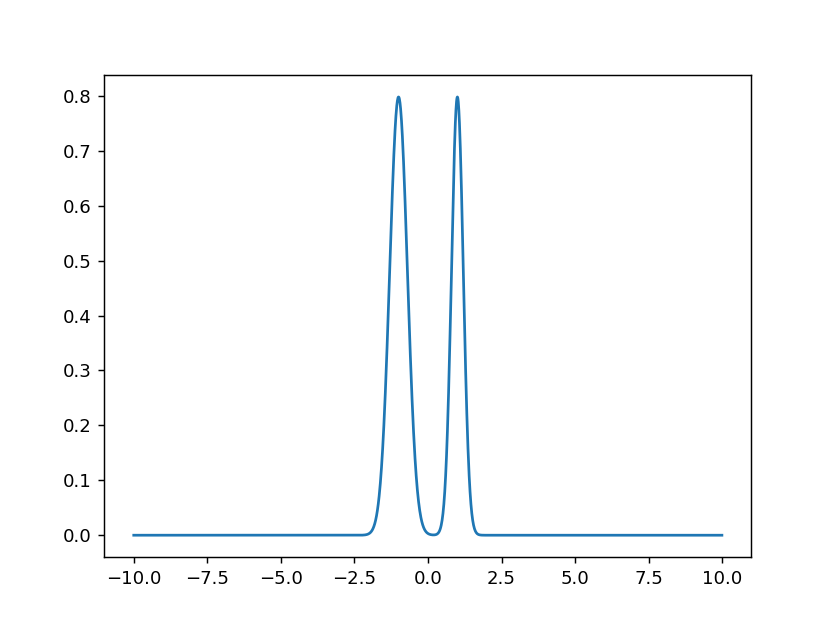

In [7]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())
plt.show()

# Variational Distribution #

In [8]:
q = MeanFieldVariationalDistribution(1)

In [9]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True);

In [10]:
n_samples_ELBO = 1000

In [11]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

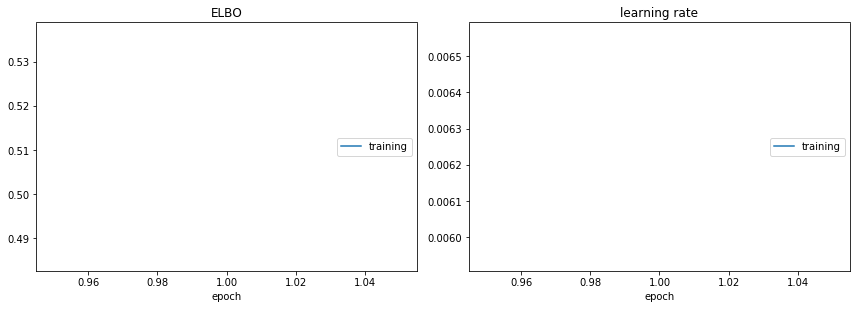

ELBO:
training   (min:    0.511, max:    0.511, cur:    0.511)

learning rate:
training   (min:    0.006, max:    0.006, cur:    0.006)


In [13]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logtarget(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.01:
        break

In [14]:
q.mu.detach_().requires_grad_(False)
q.rho.detach_().requires_grad_(False);

<IPython.core.display.Javascript object>


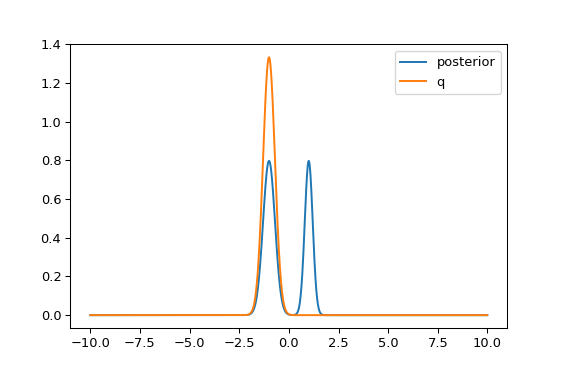

In [15]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()

In [16]:
nb_sample=200
zq=q.sample(nb_sample)
def proximity(x,seuil_prec):
    i=0
    while i< nb_sample :
        if torch.norm(zq[i]-x)< seuil_prec:
            return True
        i+=1
    return False

def updateDensity(x,log_density,seuil_prec):  
    d=[None]*x.shape[0]
    for i in range(x.shape[0]): 
        if proximity(x[i],seuil_prec):
            d[i]=torch.Tensor([-100.])
        else:
            d[i]=log_density(x[i].unsqueeze(0)).squeeze(0)#torch.Tensor(2.0)*log_density(x[i].unsqueeze(0)).squeeze(0)
#    print(d)
    return torch.cat(d,dim=0).unsqueeze(-1)

<IPython.core.display.Javascript object>


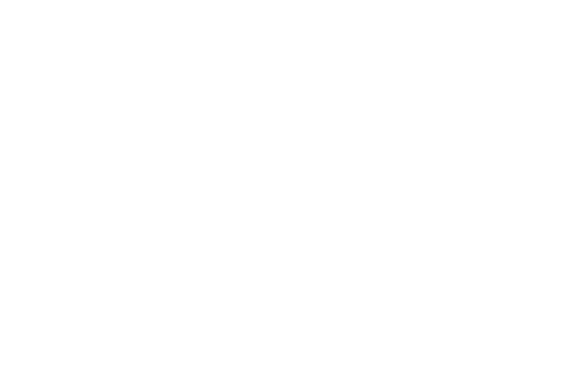

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_lin = torch.arange(-5.,5., 0.01).unsqueeze(-1)

#Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
#plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())


z=updateDensity(x_lin,logtarget,0.2)
plt.plot(x_lin.detach().numpy(), z.exp().numpy())




In [18]:

def Boost_(q):
    q_new = MeanFieldVariationalDistribution(1,mu=1.,sigma=1.)
    #q_new.mu.detach_().requires_grad_(True)
    #q_new.rho.detach_().requires_grad_(True)
    
    nb_sample=200
    zq=q.sample(nb_sample).detach()
    def proximity(x,seuil_prec):
        i=0
        while i< nb_sample :
            if torch.norm(zq[i]-x)< seuil_prec:
                return True
            i+=1
        return False

    def updateDensity(x,log_density,seuil_prec):  
        if proximity(x.detach(),seuil_prec):
            return torch.Tensor([-100.])#*log_density(x)
        else:
            return log_density(x)#torch.Tensor(2.0)*log_density(x[i].unsqueeze(0)).squeeze(0)
  
    
    nb_ELBO_samples = 20

    optimizer = torch.optim.Adam(list(q_new.parameters()), lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(10000):
        logs = {}
        optimizer.zero_grad()
        
        LQ= torch.Tensor(nb_ELBO_samples)
        LP= torch.Tensor(nb_ELBO_samples)
        
        for i in range(nb_ELBO_samples):
            z = q_new.sample()
            LQ[i]=q_new.log_prob(z)
            LP[i]=updateDensity(z,logtarget,0.2)
        
        L = (LQ - LP).mean()

        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.01:
            break
    return q_new





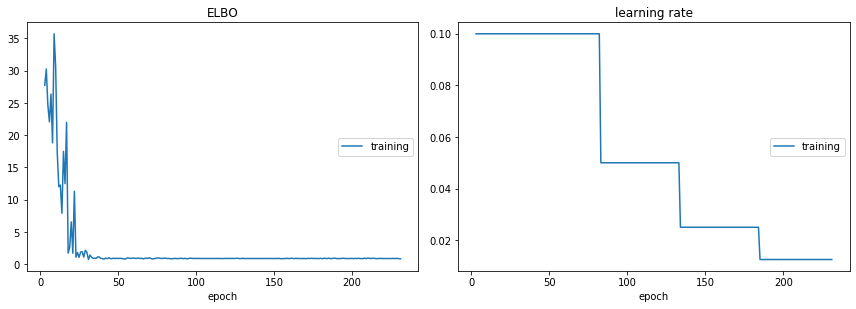

ELBO:
training   (min:    0.761, max:   35.681, cur:    0.876)

learning rate:
training   (min:    0.013, max:    0.100, cur:    0.013)


In [20]:
q_new=Boost_(q)

In [21]:
q_new.mu.detach_().requires_grad_(False)
q_new.rho.detach_().requires_grad_(False);

<IPython.core.display.Javascript object>


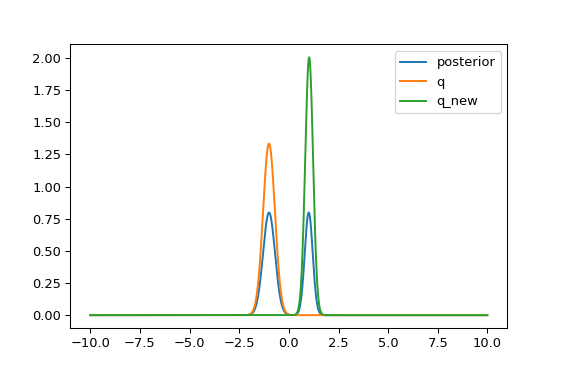

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.plot(x_lin.detach().numpy(), q_new.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q','q_new'])

In [89]:
def proportion(q,q_new):
    nb_ELBO_samples = 10000
    unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)

    optimizer = torch.optim.Adam([unbounded_prop_new], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(10000):
        logs = {}
        optimizer.zero_grad()

        Xc = q.sample(nb_ELBO_samples)
        Xnew = q_new.sample(nb_ELBO_samples)
        prop_new = torch.sigmoid(unbounded_prop_new)

        L = -(1-prop_new)*torch.mean(logtarget(Xc) - log_prob_augmented(Xc,q, q_new, prop_new)) - \
          prop_new*torch.mean(logtarget(Xnew) - log_prob_augmented(Xnew,q, q_new, prop_new))

        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
                liveloss.draw()

        optimizer.step()

        if learning_rate < 0.0001:
            break

    return torch.sigmoid(unbounded_prop_new)

In [88]:
nb_ELBO_samples = 10000
unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)

optimizer = torch.optim.Adam([unbounded_prop_new], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Xc = q.sample(nb_ELBO_samples)
    Xnew = q_new.sample(nb_ELBO_samples)
    prop_new = torch.sigmoid(unbounded_prop_new)

    L = -(1-prop_new)*torch.mean(logtarget(Xc) - log_prob_augmented(Xc,q, q_new, prop_new)) - \
      prop_new*torch.mean(logtarget(Xnew) - log_prob_augmented(Xnew,q, q_new, prop_new))

    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)

    if t % 10 == 0:
            liveloss.draw()

    optimizer.step()

    if learning_rate < 0.0001:
        break

KeyboardInterrupt: 

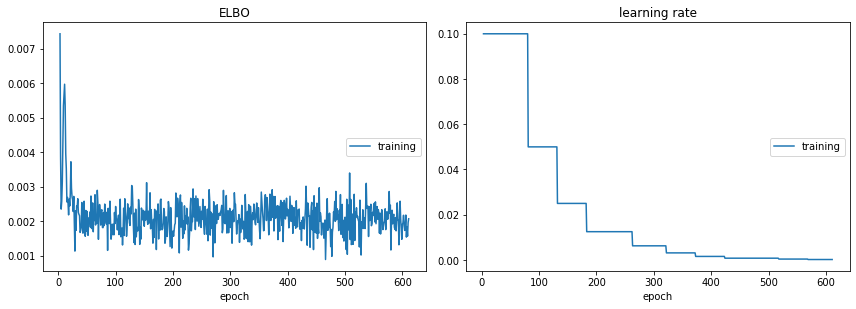

ELBO:
training   (min:    0.001, max:    0.023, cur:    0.002)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)


In [90]:
pro_new=proportion(q,q_new)

In [78]:
q_new.mu

Parameter containing:
tensor([1.0203])

<IPython.core.display.Javascript object>


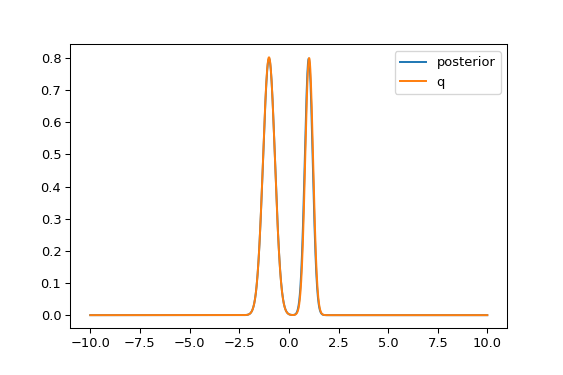

In [92]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

#plt.plot(x_lin.detach().numpy(), q.log_prob_augmented(x_lin,).exp().detach().numpy())
plt.plot(x_lin.detach().numpy(), log_prob_augmented(x_lin,q, q_new, pro_new).exp().detach().numpy())
plt.legend(['posterior', 'q','q_new'])